# Specific Task: Radiomics Feature Extraction & Phenotype Discovery
**PrediCT GSoC 2026 — Project 2(Radiomics Feature Extraction and Calcium Phenotype Discovery)**

Shreyas Chitransh

In [55]:
import os
import json
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import yaml

import nibabel as nib
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor

from scipy import stats, ndimage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"PyRadiomics version: {radiomics.__version__}")

PyRadiomics version: 3.1.1.dev111+g8ed579383


In [56]:
DATA_ROOT = Path("../coca_project")
RESAMPLED_DIR = DATA_ROOT / "data_resampled"
RESULTS_DIR = Path("../results/common_task")
OUTPUT_DIR = Path("../results/specific_task_radiomics")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

registry = pd.read_csv(RESULTS_DIR / "coca_registry_final.csv")
print(f"Registry: {len(registry)} scans, {(registry['calcium_voxels'] > 0).sum()} with calcium")
print(registry['agatston_label'].value_counts().sort_index())

Registry: 787 scans, 447 with calcium
agatston_label
Mild (1-99)           233
Moderate (100-399)     89
Severe (≥400)          99
Zero (0)              366
Name: count, dtype: int64


## Scan Selection
Picking 30 scans with calcium, ~10 from each non-zero Agatston category
to cover the full range of calcium burden.

In [57]:
calcium_scans = registry[registry['agatston_score'] > 0].copy()

selected_scans = []
for cat in [1, 2, 3]:
    cat_scans = calcium_scans[calcium_scans['agatston_category'] == cat]
    n_select = min(10, len(cat_scans))
    sampled = cat_scans.sample(n=n_select, random_state=RANDOM_SEED)
    selected_scans.append(sampled)
    print(f"Category {cat}: selected {n_select}/{len(cat_scans)}")

selected_df = pd.concat(selected_scans).reset_index(drop=True)
print(f"\nTotal selected: {len(selected_df)}")
print(f"Agatston range: {selected_df['agatston_score'].min():.1f} – {selected_df['agatston_score'].max():.1f}")

Category 1: selected 10/233
Category 2: selected 10/89
Category 3: selected 10/99

Total selected: 30
Agatston range: 0.7 – 4930.5


## PyRadiomics Setup

Starting with the required features from the task spec, then adding a
couple extra per class that are useful for the clustering/phenotyping
downstream. Also pulling first-order intensity stats since we need
those for the optional max/mean HU analysis.

- `binWidth=25` is standard for CT HU discretization
- Data is already 0.7mm isotropic so no resampling inside PyRadiomics
- `force2D=False` because calcium deposits are 3D structures

In [58]:
pyradiomics_params = {
    'setting': {
        'binWidth': 25,
        'resampledPixelSpacing': None,
        'interpolator': 'sitkBSpline',
        'minimumROIDimensions': 1,
        'minimumROISize': 1,
        'force2D': False,
        'normalize': False,
        'label': 1,
    },
    'featureClass': {
        'shape': ['Sphericity', 'SurfaceVolumeRatio', 'Maximum3DDiameter',
                  'MeshVolume', 'Elongation'],

        'firstorder': ['Mean', 'Maximum', 'StandardDeviation', 'Entropy', 'Skewness'],

        'glcm': ['Contrast', 'Correlation', 'Idm',
                 'JointEntropy', 'ClusterShade'],

        'glszm': ['SmallAreaEmphasis', 'LargeAreaEmphasis', 'ZonePercentage',
                  'GrayLevelNonUniformity', 'ZoneEntropy'],

        'glrlm': ['ShortRunEmphasis', 'LongRunEmphasis', 'RunPercentage',
                  'GrayLevelNonUniformity', 'RunEntropy'],
    }
}

params_file = OUTPUT_DIR / 'pyradiomics_params.yaml'
with open(params_file, 'w') as f:
    yaml.dump({'setting': pyradiomics_params['setting'],
               'featureClass': pyradiomics_params['featureClass']}, f, default_flow_style=False)

total_feats = sum(len(v) for v in pyradiomics_params['featureClass'].values())
print(f"Config saved. {total_feats} PyRadiomics features across {len(pyradiomics_params['featureClass'])} classes.")

extractor = featureextractor.RadiomicsFeatureExtractor(str(params_file))

Config saved. 25 PyRadiomics features across 5 classes.


## Feature Extraction
For each scan: load NIfTI → convert to SimpleITK → run PyRadiomics → add custom
features (max/mean HU, volume, lesion count, inter-lesion distances).

The custom features cover spatial distribution stuff that PyRadiomics doesn't
do — things like how many separate calcium deposits there are and how far
apart they sit, which matters for distinguishing spotty vs diffuse patterns.

In [59]:
def nib_to_sitk(nib_img):
    data = nib_img.get_fdata().astype(np.float32)
    affine = nib_img.affine
    sitk_img = sitk.GetImageFromArray(data.transpose(2, 1, 0))
    spacing = nib_img.header.get_zooms()
    sitk_img.SetSpacing([float(s) for s in spacing])
    origin = affine[:3, 3]
    sitk_img.SetOrigin([float(o) for o in origin])
    rotation = affine[:3, :3]
    spacing_arr = np.array(spacing)
    direction_matrix = rotation / spacing_arr[np.newaxis, :]
    sitk_img.SetDirection(direction_matrix.flatten().tolist())
    return sitk_img


def compute_custom_features(img_data, seg_data, spacing):
    """Lesion-level and spatial features not available in PyRadiomics."""
    calcium_mask = seg_data > 0
    voxel_volume = float(np.prod(spacing))
    features = {}

    if not calcium_mask.any():
        return {k: 0.0 for k in [
            'custom_max_calcium_hu', 'custom_mean_calcium_hu',
            'custom_total_calcium_volume_mm3', 'custom_lesion_count',
            'custom_mean_lesion_volume_mm3',
            'custom_max_inter_lesion_distance_mm',
            'custom_mean_inter_lesion_distance_mm'
        ]}

    calcium_hu = img_data[calcium_mask]
    features['custom_max_calcium_hu'] = float(calcium_hu.max())
    features['custom_mean_calcium_hu'] = float(calcium_hu.mean())
    features['custom_total_calcium_volume_mm3'] = float(calcium_mask.sum() * voxel_volume)

    labeled, n_lesions = ndimage.label(calcium_mask)
    features['custom_lesion_count'] = n_lesions

    if n_lesions > 0:
        lesion_volumes = []
        centroids = []
        for lid in range(1, n_lesions + 1):
            lmask = labeled == lid
            lesion_volumes.append(lmask.sum() * voxel_volume)
            coords = np.argwhere(lmask).mean(axis=0)
            centroids.append(coords * np.array(spacing))

        features['custom_mean_lesion_volume_mm3'] = float(np.mean(lesion_volumes))

        if n_lesions > 1:
            dists = pdist(np.array(centroids), metric='euclidean')
            features['custom_max_inter_lesion_distance_mm'] = float(dists.max())
            features['custom_mean_inter_lesion_distance_mm'] = float(dists.mean())
        else:
            features['custom_max_inter_lesion_distance_mm'] = 0.0
            features['custom_mean_inter_lesion_distance_mm'] = 0.0
    else:
        features['custom_mean_lesion_volume_mm3'] = 0.0
        features['custom_max_inter_lesion_distance_mm'] = 0.0
        features['custom_mean_inter_lesion_distance_mm'] = 0.0

    return features

In [60]:
print(f"Extracting features from {len(selected_df)} scans...\n")

all_features = []
failed_scans = []

for idx, row in selected_df.iterrows():
    scan_id = row['scan_id']
    try:
        img_nib = nib.load(row['img_path'])
        seg_nib = nib.load(row['seg_path'])
        img_data = img_nib.get_fdata()
        seg_data = seg_nib.get_fdata()
        spacing = img_nib.header.get_zooms()

        seg_binary = (seg_data > 0).astype(np.int32)
        if seg_binary.sum() == 0:
            print(f"  [{idx+1}] {scan_id}: SKIP (empty mask)")
            failed_scans.append(scan_id)
            continue

        img_sitk = nib_to_sitk(img_nib)
        seg_nib_int = nib.Nifti1Image(seg_binary.astype(np.float32), seg_nib.affine, seg_nib.header)
        seg_sitk = sitk.Cast(nib_to_sitk(seg_nib_int), sitk.sitkInt32)

        result = extractor.execute(img_sitk, seg_sitk)

        feature_dict = {
            'scan_id': scan_id,
            'patient_id': row['patient_id'],
            'agatston_score': row['agatston_score'],
            'agatston_category': row['agatston_category'],
            'agatston_label': row['agatston_label'],
        }

        for key, val in result.items():
            if not key.startswith('diagnostics_'):
                clean_key = key.replace('original_', '')
                feature_dict[clean_key] = float(val) if hasattr(val, '__float__') else val

        custom = compute_custom_features(img_data, seg_data, spacing)
        feature_dict.update(custom)
        all_features.append(feature_dict)

        if (idx + 1) % 5 == 0 or idx == 0:
            n_feat = len([k for k in feature_dict if k not in
                         ['scan_id', 'patient_id', 'agatston_score', 'agatston_category', 'agatston_label']])
            print(f"  [{idx+1}/{len(selected_df)}] {scan_id}: {n_feat} features (Agatston={row['agatston_score']:.1f})")

    except Exception as e:
        print(f"  [{idx+1}] {scan_id}: FAILED — {str(e)[:80]}")
        failed_scans.append(scan_id)

print(f"\nDone: {len(all_features)} ok, {len(failed_scans)} failed")

Extracting features from 30 scans...



Feature StandardDeviation is deprecated, use with caution!


  [1/30] 7e4d95f285eb: 32 features (Agatston=9.4)


Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!


  [5/30] 6adeec58f883: 32 features (Agatston=5.8)


Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!


  [10/30] 658bd094e3e5: 32 features (Agatston=4.0)


Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!


  [15/30] a17e2de304ca: 32 features (Agatston=265.0)


Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!


  [20/30] 71ed315a6fe4: 32 features (Agatston=278.2)


Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!


  [25/30] bf167b8c8802: 32 features (Agatston=561.0)


Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!


  [30/30] 08efde4aa24b: 32 features (Agatston=484.9)

Done: 30 ok, 0 failed


In [61]:
features_df = pd.DataFrame(all_features)
metadata_cols = ['scan_id', 'patient_id', 'agatston_score', 'agatston_category', 'agatston_label']
feature_cols = [c for c in features_df.columns if c not in metadata_cols]

print(f"Feature matrix: {features_df.shape[0]} scans × {len(feature_cols)} features\n")

feature_groups = {}
for col in feature_cols:
    prefix = col.split('_')[0]
    feature_groups.setdefault(prefix, []).append(col)
for group, cols in sorted(feature_groups.items()):
    print(f"  {group}: {len(cols)}")

Feature matrix: 30 scans × 32 features

  custom: 7
  firstorder: 5
  glcm: 5
  glrlm: 5
  glszm: 5
  shape: 5


In [62]:
features_df.to_csv(OUTPUT_DIR / 'radiomics_features.csv', index=False)
print(f"Saved to {OUTPUT_DIR / 'radiomics_features.csv'}")

Saved to ../results/specific_task_radiomics/radiomics_features.csv


## Feature Distributions

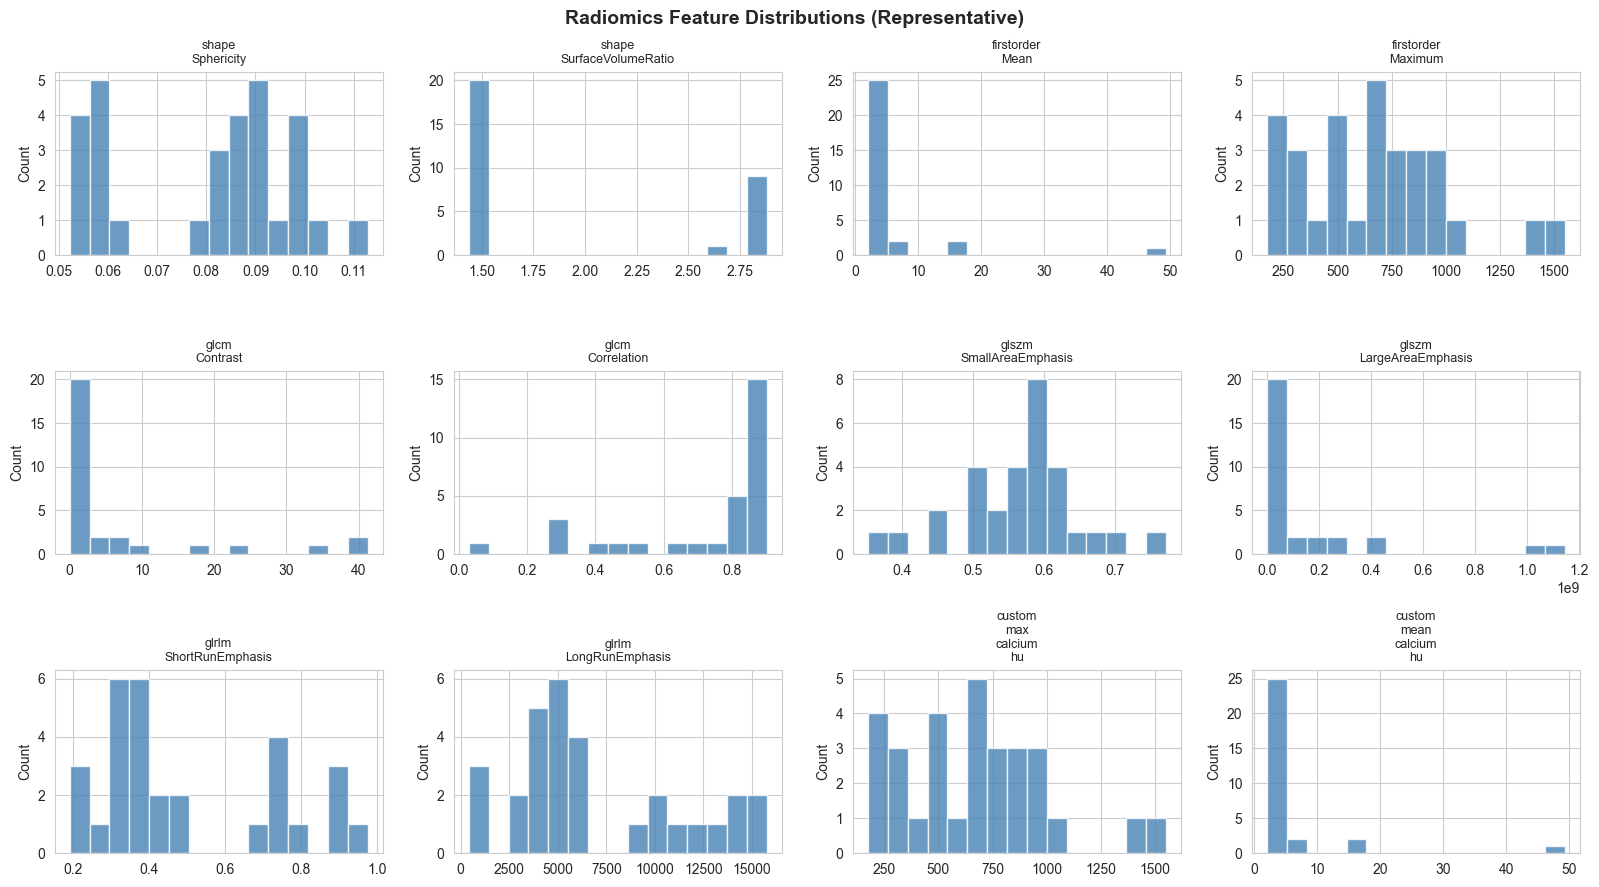

In [63]:
representative_features = []
for group in ['shape', 'firstorder', 'glcm', 'glszm', 'glrlm', 'custom']:
    group_feats = [c for c in feature_cols if c.startswith(group)]
    if group_feats:
        representative_features.extend(group_feats[:2])

n_feats = len(representative_features)
n_cols = 4
n_rows = (n_feats + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
axes = axes.flatten()

for i, feat in enumerate(representative_features):
    axes[i].hist(features_df[feat].dropna(), bins=15, color='steelblue', edgecolor='white', alpha=0.8)
    axes[i].set_title(feat.replace('_', '\n'), fontsize=9)
    axes[i].set_ylabel('Count')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Radiomics Feature Distributions (Representative)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## Statistical Analysis
Spearman rank correlation (monotonic association with Agatston) and Kruskal-Wallis
(distributional differences across Mild/Moderate/Severe).

In [64]:
agatston_values = features_df['agatston_score'].values

spearman_results = []
for feat in feature_cols:
    feat_values = features_df[feat].values
    valid = np.isfinite(feat_values) & np.isfinite(agatston_values)
    if valid.sum() < 5:
        continue
    rho, pval = stats.spearmanr(feat_values[valid], agatston_values[valid])
    spearman_results.append({
        'feature': feat, 'spearman_rho': rho, 'p_value': pval,
        'significant': pval < 0.05, 'abs_rho': abs(rho),
    })

spearman_df = pd.DataFrame(spearman_results).sort_values('abs_rho', ascending=False)
print(f"Significant (p<0.05): {spearman_df['significant'].sum()}/{len(spearman_df)}\n")
print("Top 15 by |ρ|:")
print(spearman_df.head(15)[['feature', 'spearman_rho', 'p_value', 'significant']].to_string(index=False))
spearman_df.to_csv(OUTPUT_DIR / 'spearman_correlation.csv', index=False)

Significant (p<0.05): 24/32

Top 15 by |ρ|:
                     feature  spearman_rho      p_value  significant
           glszm_ZoneEntropy      0.979978 3.606584e-21         True
            glrlm_RunEntropy      0.966630 4.240242e-18         True
firstorder_StandardDeviation      0.963960 1.225124e-17         True
          firstorder_Entropy      0.959066 7.068084e-17         True
glszm_GrayLevelNonUniformity      0.950167 1.050510e-15         True
        glszm_ZonePercentage      0.950167 1.050510e-15         True
      custom_mean_calcium_hu      0.933704 5.157534e-14         True
             firstorder_Mean      0.933704 5.157534e-14         True
          firstorder_Maximum      0.905228 6.417487e-12         True
       custom_max_calcium_hu      0.905228 6.417487e-12         True
         firstorder_Skewness     -0.904338 7.273476e-12         True
     glszm_LargeAreaEmphasis     -0.895439 2.387968e-11         True
       glrlm_LongRunEmphasis     -0.889655 4.891105e-11    

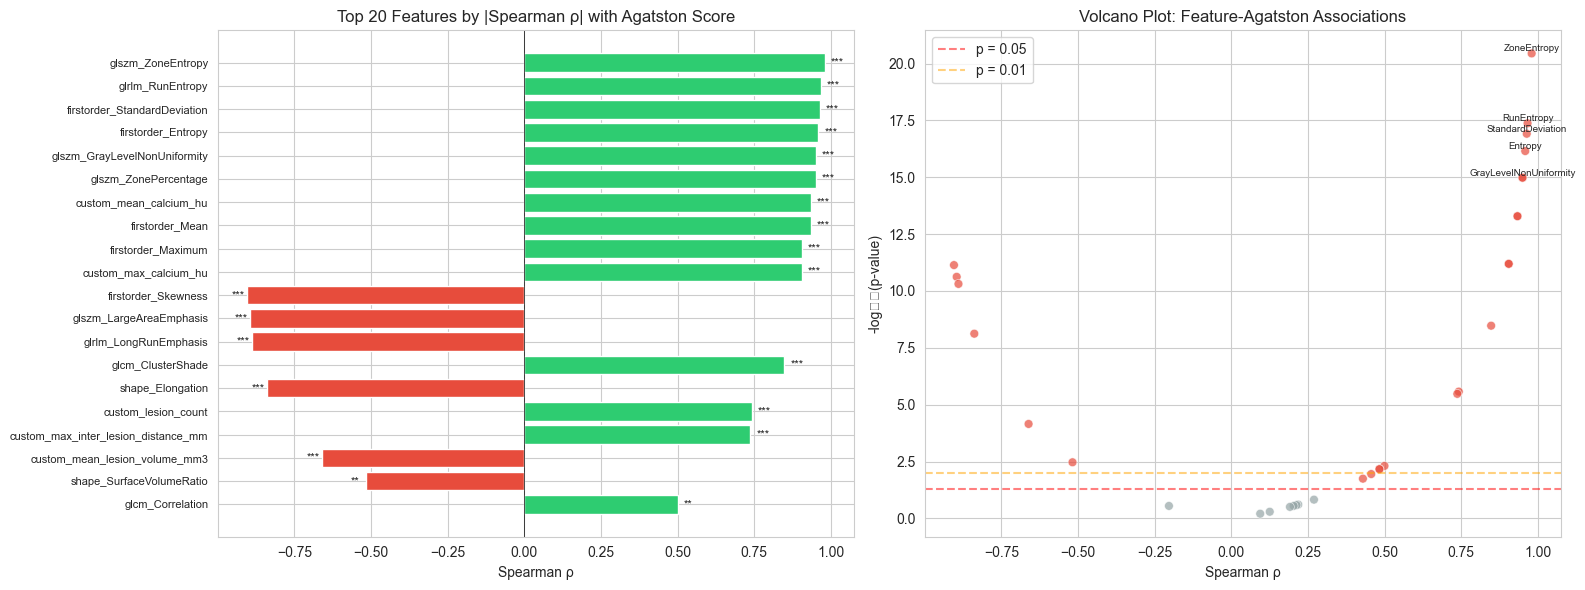

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_n = min(20, len(spearman_df))
top_spearman = spearman_df.head(top_n)
colors = ['#e74c3c' if r < 0 else '#2ecc71' for r in top_spearman['spearman_rho']]
axes[0].barh(range(top_n), top_spearman['spearman_rho'].values, color=colors, edgecolor='white')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_spearman['feature'].values, fontsize=8)
axes[0].set_xlabel('Spearman ρ')
axes[0].set_title(f'Top {top_n} Features by |Spearman ρ| with Agatston Score')
axes[0].axvline(x=0, color='black', linewidth=0.5)
axes[0].invert_yaxis()

for i, (_, row) in enumerate(top_spearman.iterrows()):
    marker = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else 'ns'
    x_pos = row['spearman_rho'] + 0.02 if row['spearman_rho'] >= 0 else row['spearman_rho'] - 0.05
    axes[0].text(x_pos, i, marker, fontsize=8, va='center')

axes[1].scatter(spearman_df['spearman_rho'],
                -np.log10(spearman_df['p_value'].clip(1e-50)),
                c=spearman_df['significant'].map({True: '#e74c3c', False: '#95a5a6'}),
                alpha=0.7, s=40, edgecolors='white', linewidth=0.5)
axes[1].axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='p = 0.05')
axes[1].axhline(y=-np.log10(0.01), color='orange', linestyle='--', alpha=0.5, label='p = 0.01')
axes[1].set_xlabel('Spearman ρ')
axes[1].set_ylabel('-log₁₀(p-value)')
axes[1].set_title('Volcano Plot: Feature-Agatston Associations')
axes[1].legend()

for _, row in spearman_df.head(5).iterrows():
    axes[1].annotate(row['feature'].split('_')[-1],
                     (row['spearman_rho'], -np.log10(max(row['p_value'], 1e-50))),
                     fontsize=7, ha='center', va='bottom')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'spearman_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

In [66]:
categories = sorted(features_df['agatston_category'].unique())

kruskal_results = []
for feat in feature_cols:
    groups = [features_df[features_df['agatston_category'] == cat][feat].dropna().values
              for cat in categories]
    groups = [g for g in groups if len(g) >= 2]
    if len(groups) < 2:
        continue
    h_stat, pval = stats.kruskal(*groups)
    kruskal_results.append({'feature': feat, 'h_statistic': h_stat, 'p_value': pval, 'significant': pval < 0.05})

kruskal_df = pd.DataFrame(kruskal_results).sort_values('h_statistic', ascending=False)
print(f"Significant (p<0.05): {kruskal_df['significant'].sum()}/{len(kruskal_df)}\n")
print("Top 15:")
print(kruskal_df.head(15)[['feature', 'h_statistic', 'p_value', 'significant']].to_string(index=False))
kruskal_df.to_csv(OUTPUT_DIR / 'kruskal_wallis.csv', index=False)

Significant (p<0.05): 22/32

Top 15:
                     feature  h_statistic  p_value  significant
            glrlm_RunEntropy    25.806452 0.000002         True
glszm_GrayLevelNonUniformity    24.815484 0.000004         True
           glszm_ZoneEntropy    24.815484 0.000004         True
          firstorder_Entropy    23.692903 0.000007         True
firstorder_StandardDeviation    23.483871 0.000008         True
        glszm_ZonePercentage    22.407742 0.000014         True
         firstorder_Skewness    21.677419 0.000020         True
      custom_mean_calcium_hu    20.449032 0.000036         True
             firstorder_Mean    20.449032 0.000036         True
          firstorder_Maximum    20.015484 0.000045         True
       custom_max_calcium_hu    20.015484 0.000045         True
     glszm_LargeAreaEmphasis    19.140645 0.000070         True
       glrlm_LongRunEmphasis    19.117419 0.000071         True
         custom_lesion_count    19.110993 0.000071         True
   

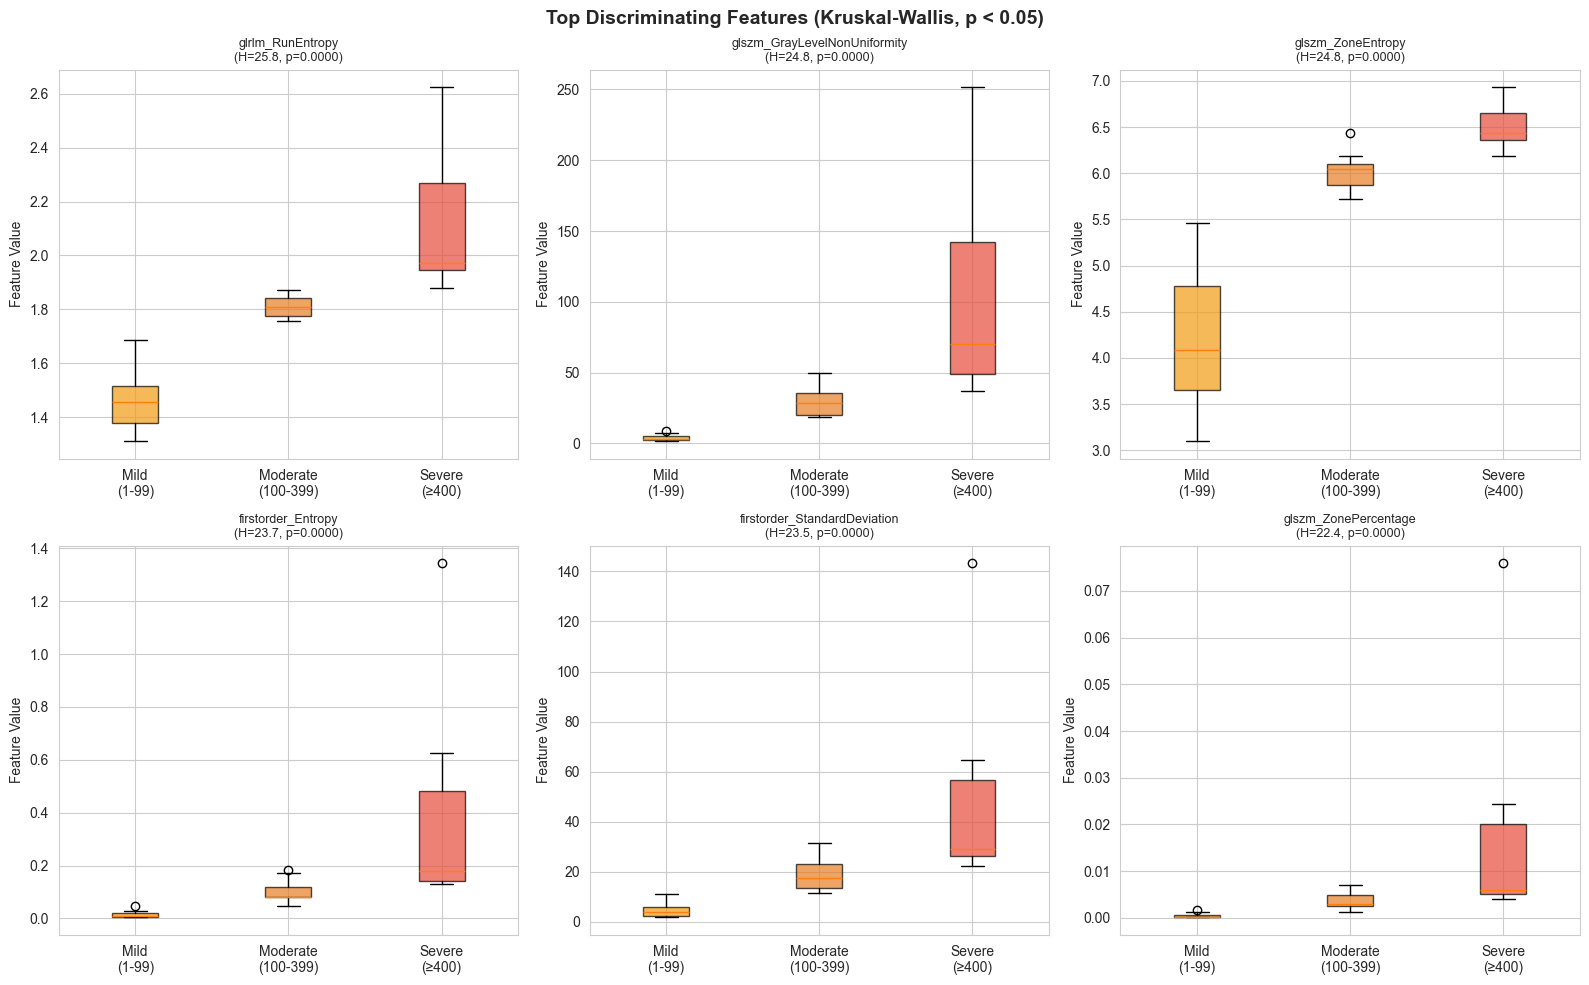

In [67]:
top_kw = kruskal_df[kruskal_df['significant']].head(6)
if len(top_kw) > 0:
    n_plots = min(6, len(top_kw))
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    category_labels = {1: 'Mild\n(1-99)', 2: 'Moderate\n(100-399)', 3: 'Severe\n(≥400)'}

    for i, (_, row) in enumerate(top_kw.head(n_plots).iterrows()):
        feat = row['feature']
        ax = axes[i]
        plot_data, plot_labels = [], []
        for cat in categories:
            cat_data = features_df[features_df['agatston_category'] == cat][feat].dropna()
            if len(cat_data) > 0:
                plot_data.append(cat_data.values)
                plot_labels.append(category_labels.get(cat, str(cat)))

        bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True, boxprops=dict(alpha=0.7))
        for patch, color in zip(bp['boxes'], ['#f39c12', '#e67e22', '#e74c3c'][:len(bp['boxes'])]):
            patch.set_facecolor(color)
        ax.set_title(f'{feat}\n(H={row["h_statistic"]:.1f}, p={row["p_value"]:.4f})', fontsize=9)
        ax.set_ylabel('Feature Value')

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Top Discriminating Features (Kruskal-Wallis, p < 0.05)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'kruskal_wallis_boxplots.png', dpi=150, bbox_inches='tight')
    plt.show()

## Correlation Matrix

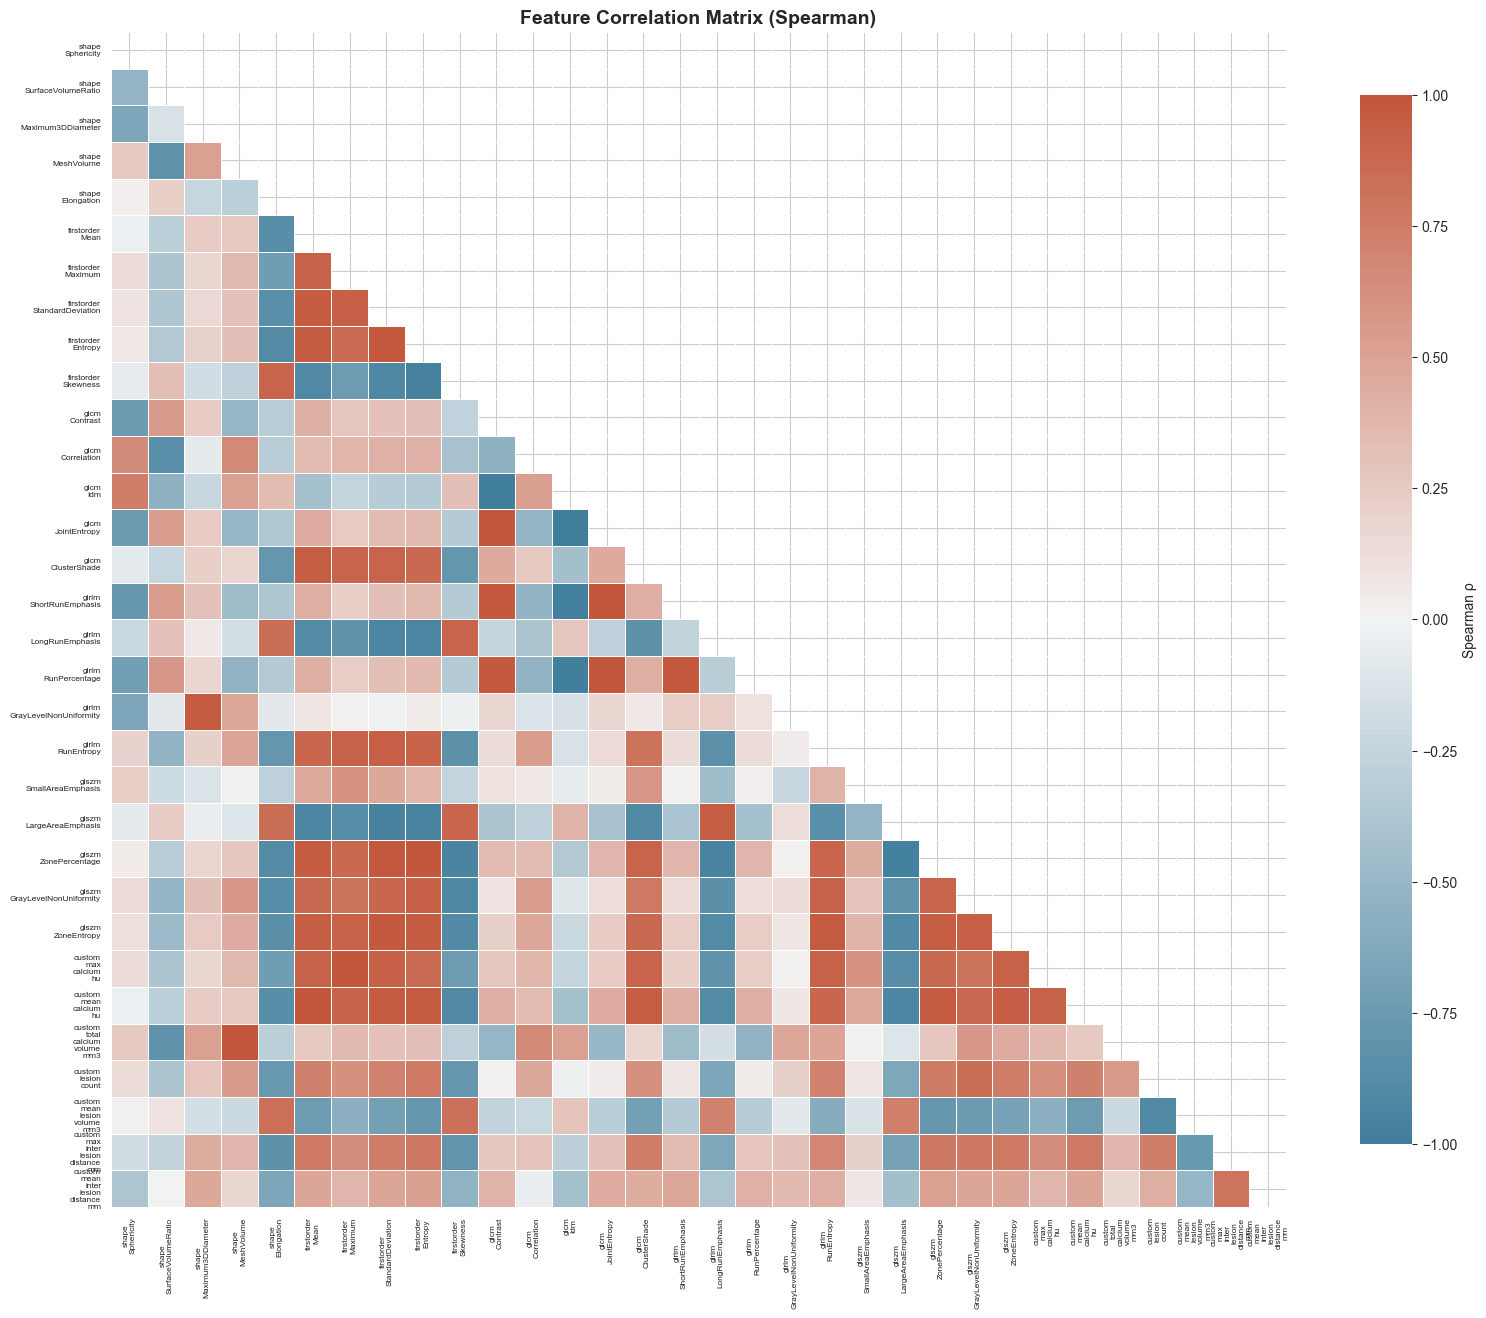

In [68]:
feature_matrix = features_df[feature_cols].dropna(axis=1)
corr_matrix = feature_matrix.corr(method='spearman')

fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap=sns.diverging_palette(230, 20, as_cmap=True),
            center=0, square=True, linewidths=0.5,
            xticklabels=[c.replace('_', '\n') for c in corr_matrix.columns],
            yticklabels=[c.replace('_', '\n') for c in corr_matrix.columns],
            cbar_kws={"shrink": 0.8, "label": "Spearman ρ"}, ax=ax, vmin=-1, vmax=1)
ax.set_title('Feature Correlation Matrix (Spearman)', fontsize=14, fontweight='bold')
ax.tick_params(axis='both', labelsize=6)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

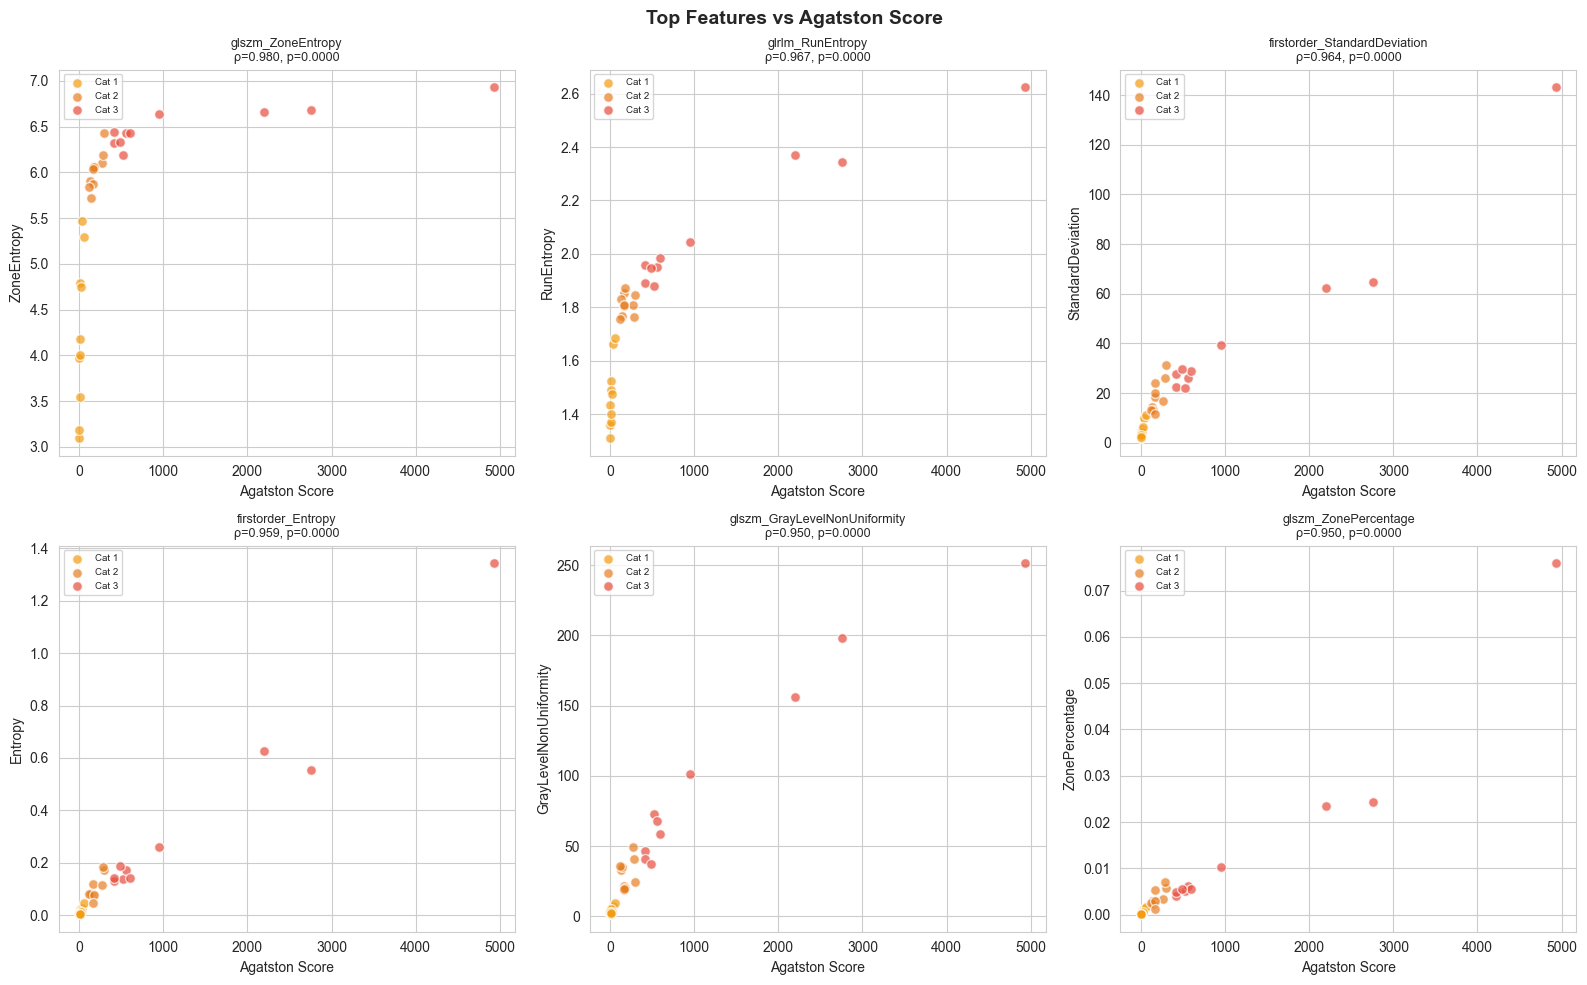

In [69]:
top_corr_features = spearman_df.head(6)['feature'].values
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()
color_map = {1: '#f39c12', 2: '#e67e22', 3: '#e74c3c'}
label_map = {1: 'Mild (1-99)', 2: 'Moderate (100-399)', 3: 'Severe (≥400)'}

for i, feat in enumerate(top_corr_features):
    ax = axes[i]
    for cat in sorted(features_df['agatston_category'].unique()):
        subset = features_df[features_df['agatston_category'] == cat]
        ax.scatter(subset['agatston_score'], subset[feat],
                  c=color_map.get(cat, '#95a5a6'), alpha=0.7, label=f'Cat {cat}', s=50, edgecolors='white')

    rho = spearman_df[spearman_df['feature'] == feat]['spearman_rho'].values[0]
    pval = spearman_df[spearman_df['feature'] == feat]['p_value'].values[0]
    ax.set_xlabel('Agatston Score')
    ax.set_ylabel(feat.split('_', 1)[-1] if '_' in feat else feat)
    ax.set_title(f'{feat}\nρ={rho:.3f}, p={pval:.4f}', fontsize=9)
    ax.legend(fontsize=7)

plt.suptitle('Top Features vs Agatston Score', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_vs_agatston_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## PCA
Standardize → PCA to find the main axes of variation. Looking at how many
components it takes to hit 90% variance and whether the Agatston categories
separate along the principal components.

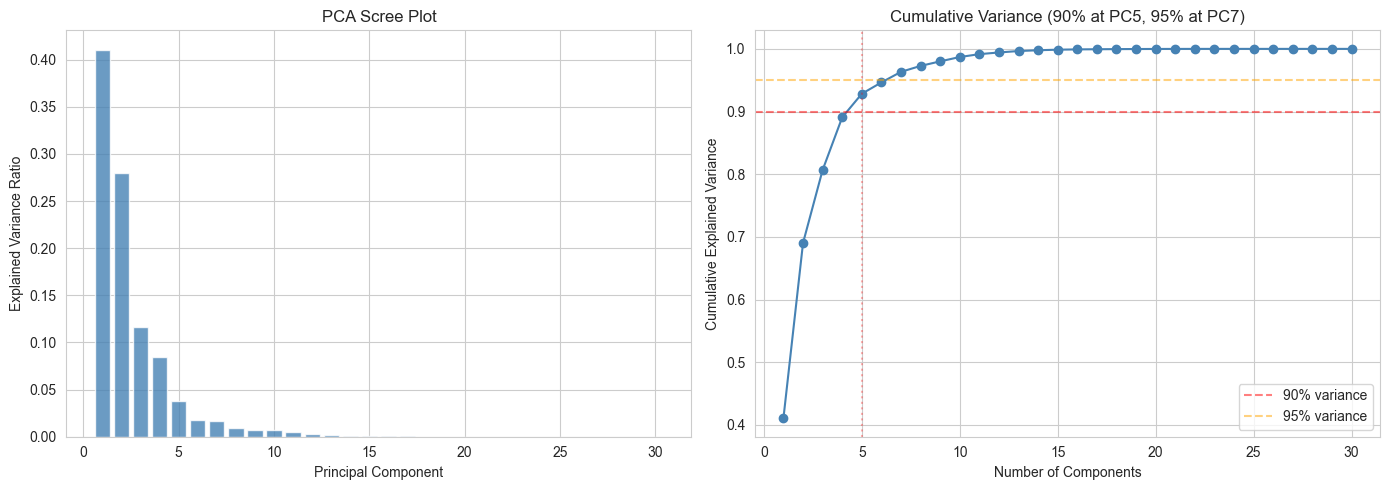

PC1: 41.1%, PC2: 28.0%


In [70]:
feature_matrix_clean = features_df[feature_cols].dropna(axis=1).copy()
non_constant = feature_matrix_clean.columns[feature_matrix_clean.std() > 1e-10]
feature_matrix_clean = feature_matrix_clean[non_constant]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_matrix_clean)
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

pca = PCA(random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1),
            pca.explained_variance_ratio_, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Scree Plot')

cumvar = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, len(cumvar) + 1), cumvar, 'o-', color='steelblue')
axes[1].axhline(y=0.90, color='red', linestyle='--', alpha=0.5, label='90% variance')
axes[1].axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='95% variance')
n_90 = np.argmax(cumvar >= 0.90) + 1
n_95 = np.argmax(cumvar >= 0.95) + 1
axes[1].axvline(x=n_90, color='red', linestyle=':', alpha=0.3)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title(f'Cumulative Variance (90% at PC{n_90}, 95% at PC{n_95})')
axes[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'pca_variance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"PC1: {pca.explained_variance_ratio_[0]*100:.1f}%, PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")

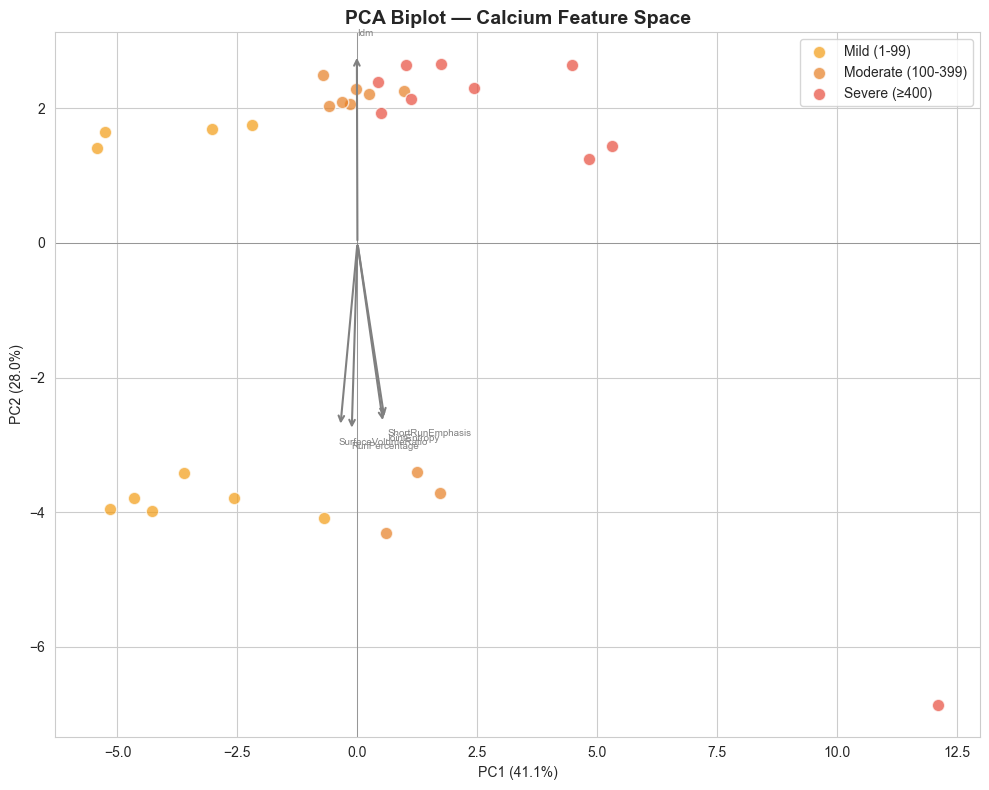

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))

for cat in sorted(features_df['agatston_category'].unique()):
    mask = features_df['agatston_category'].values == cat
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color_map.get(cat, '#95a5a6'),
              label=label_map.get(cat, f'Cat {cat}'), s=80, alpha=0.7, edgecolors='white')

n_arrows = 5
loadings = pca.components_[:2].T
feature_names = list(feature_matrix_clean.columns)
loading_magnitudes = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)
top_loading_idx = np.argsort(loading_magnitudes)[-n_arrows:]

scale = max(abs(X_pca[:, 0]).max(), abs(X_pca[:, 1]).max()) * 0.7
for idx in top_loading_idx:
    ax.annotate('', xy=(loadings[idx, 0] * scale, loadings[idx, 1] * scale), xytext=(0, 0),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
    ax.text(loadings[idx, 0] * scale * 1.1, loadings[idx, 1] * scale * 1.1,
            feature_names[idx].split('_')[-1], fontsize=7, color='gray')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA Biplot — Calcium Feature Space', fontsize=14, fontweight='bold')
ax.legend()
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'pca_biplot.png', dpi=150, bbox_inches='tight')
plt.show()

## t-SNE & UMAP

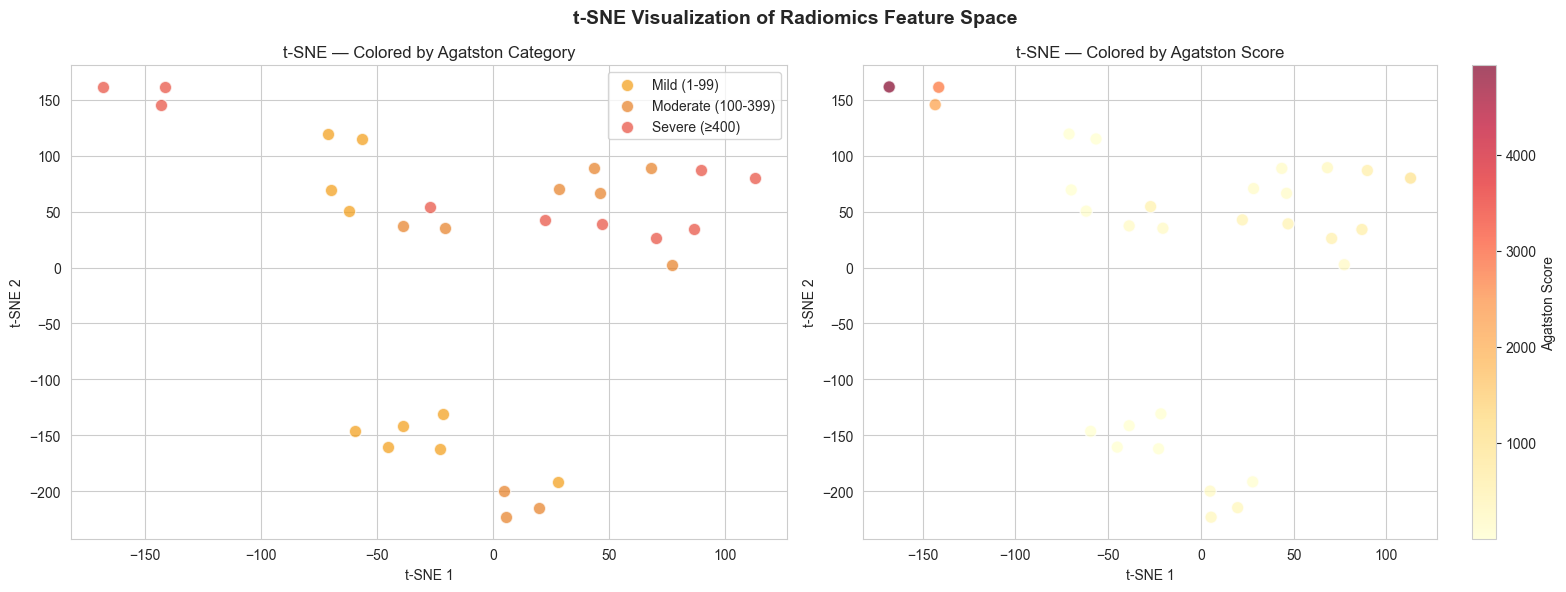

In [72]:
perplexity = min(5, len(X_scaled) - 1)
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=perplexity,
            max_iter=1000, learning_rate='auto', init='pca')
X_tsne = tsne.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for cat in sorted(features_df['agatston_category'].unique()):
    mask = features_df['agatston_category'].values == cat
    axes[0].scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color_map.get(cat, '#95a5a6'),
                   label=label_map.get(cat, f'Cat {cat}'), s=80, alpha=0.7, edgecolors='white')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].set_title('t-SNE — Colored by Agatston Category')
axes[0].legend()

scatter = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=features_df['agatston_score'],
                          cmap='YlOrRd', s=80, alpha=0.7, edgecolors='white')
plt.colorbar(scatter, ax=axes[1], label='Agatston Score')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('t-SNE — Colored by Agatston Score')

plt.suptitle('t-SNE Visualization of Radiomics Feature Space', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

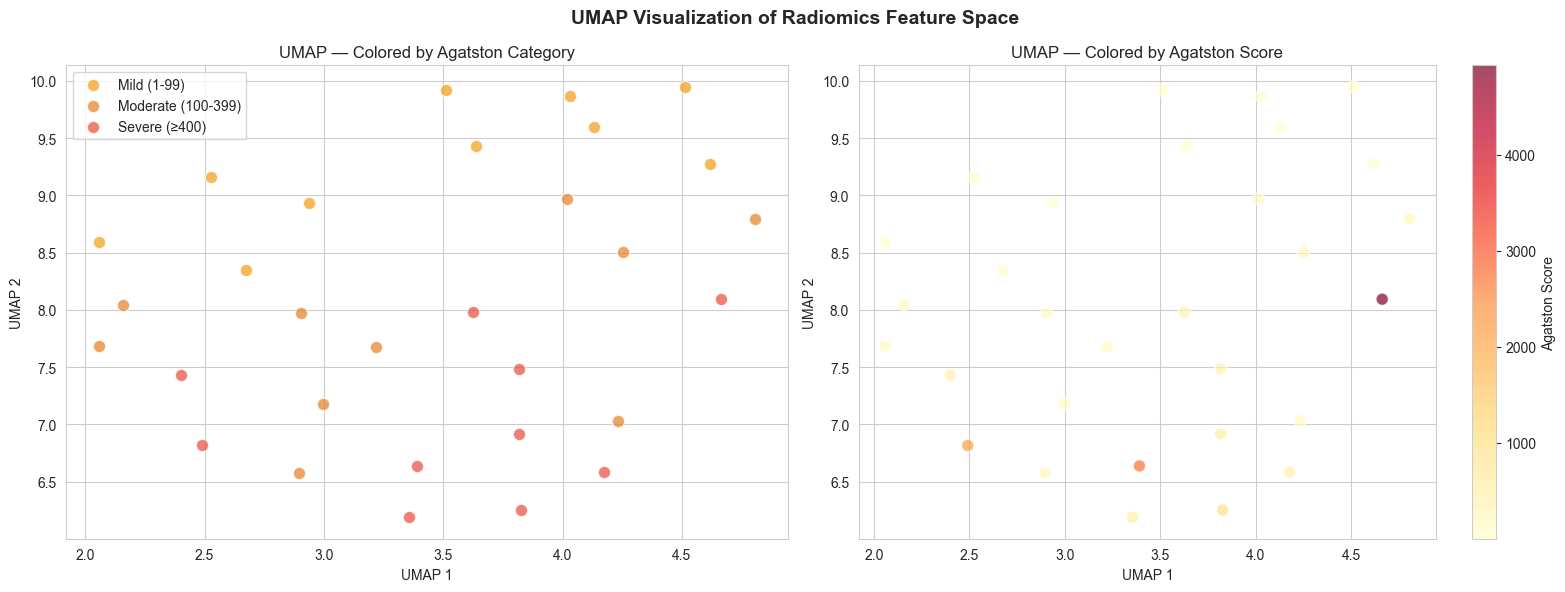

In [73]:
try:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_SEED,
                        n_neighbors=min(10, len(X_scaled) - 1), min_dist=0.1)
    X_umap = reducer.fit_transform(X_scaled)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    for cat in sorted(features_df['agatston_category'].unique()):
        mask = features_df['agatston_category'].values == cat
        axes[0].scatter(X_umap[mask, 0], X_umap[mask, 1], c=color_map.get(cat, '#95a5a6'),
                       label=label_map.get(cat, f'Cat {cat}'), s=80, alpha=0.7, edgecolors='white')
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    axes[0].set_title('UMAP — Colored by Agatston Category')
    axes[0].legend()

    scatter = axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=features_df['agatston_score'],
                              cmap='YlOrRd', s=80, alpha=0.7, edgecolors='white')
    plt.colorbar(scatter, ax=axes[1], label='Agatston Score')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].set_title('UMAP — Colored by Agatston Score')

    plt.suptitle('UMAP Visualization of Radiomics Feature Space', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'umap_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
except ImportError:
    print("umap-learn not installed, skipping. pip install umap-learn")

## Clustering — Phenotype Discovery
K-Means with silhouette/Calinski-Harabasz for picking K, plus Ward hierarchical
for the dendrogram. Then we look at how clusters map onto Agatston categories.

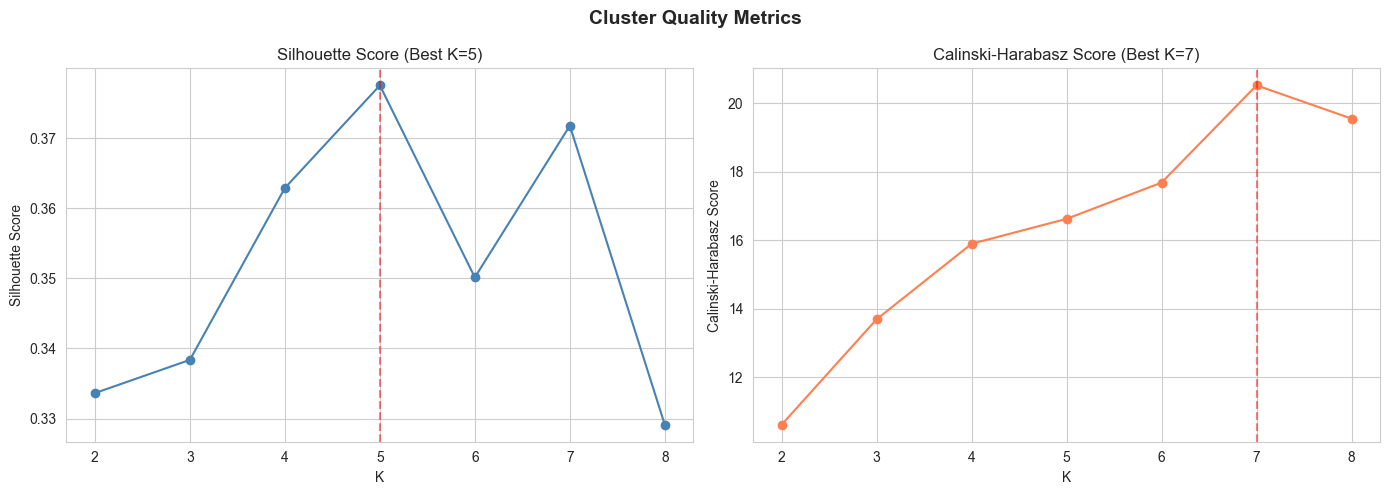

Using K=5


In [74]:
max_k = min(8, len(X_scaled) - 1)
k_range = range(2, max_k + 1)

sil_scores, cal_scores = [], []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))
    cal_scores.append(calinski_harabasz_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

best_k_sil = list(k_range)[np.argmax(sil_scores)]
axes[0].plot(list(k_range), sil_scores, 'o-', color='steelblue')
axes[0].axvline(x=best_k_sil, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('K')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title(f'Silhouette Score (Best K={best_k_sil})')

best_k_cal = list(k_range)[np.argmax(cal_scores)]
axes[1].plot(list(k_range), cal_scores, 'o-', color='coral')
axes[1].axvline(x=best_k_cal, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('K')
axes[1].set_ylabel('Calinski-Harabasz Score')
axes[1].set_title(f'Calinski-Harabasz Score (Best K={best_k_cal})')

plt.suptitle('Cluster Quality Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cluster_quality_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

optimal_k = max(3, best_k_sil)
print(f"Using K={optimal_k}")

In [75]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=RANDOM_SEED, n_init=20)
cluster_labels = kmeans_final.fit_predict(X_scaled)
features_df['cluster_kmeans'] = cluster_labels

print(f"Cluster sizes: {dict(Counter(cluster_labels))}")
print(f"Silhouette: {silhouette_score(X_scaled, cluster_labels):.3f}")

Cluster sizes: {np.int32(3): 5, np.int32(1): 4, np.int32(0): 4, np.int32(2): 16, np.int32(4): 1}
Silhouette: 0.378


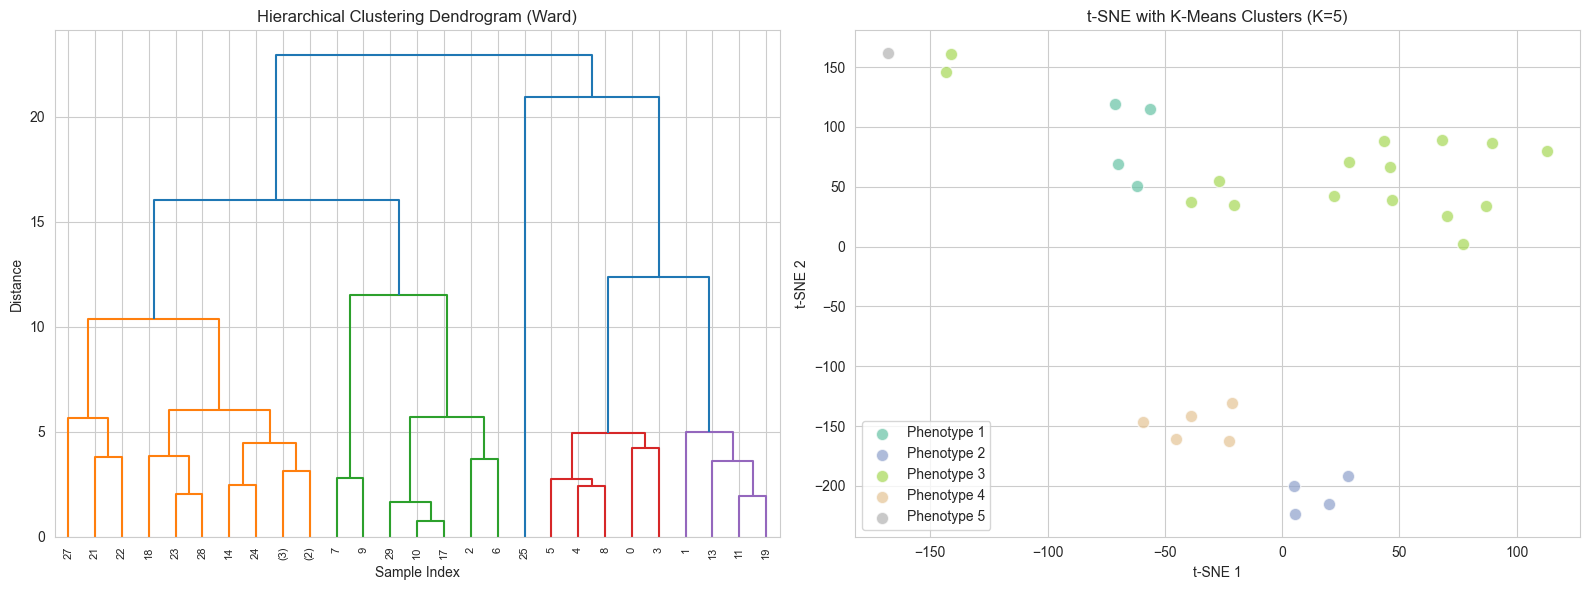

In [76]:
linkage_matrix = linkage(X_scaled, method='ward', metric='euclidean')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

dendrogram(linkage_matrix, ax=axes[0], truncate_mode='level', p=5,
           leaf_rotation=90, leaf_font_size=8,
           color_threshold=linkage_matrix[-optimal_k + 1, 2])
axes[0].set_title('Hierarchical Clustering Dendrogram (Ward)')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Distance')

cluster_colors = plt.cm.Set2(np.linspace(0, 1, optimal_k))
for c in range(optimal_k):
    mask = cluster_labels == c
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=[cluster_colors[c]],
                   label=f'Phenotype {c+1}', s=80, alpha=0.7, edgecolors='white')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f't-SNE with K-Means Clusters (K={optimal_k})')
axes[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'clustering_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Phenotype Characterization

Phenotype × Agatston crosstab:
agatston_label  Mild (1-99)  Moderate (100-399)  Severe (≥400)  All
cluster_kmeans                                                     
0                         4                   0              0    4
1                         1                   3              0    4
2                         0                   7              9   16
3                         5                   0              0    5
4                         0                   0              1    1
All                      10                  10             10   30


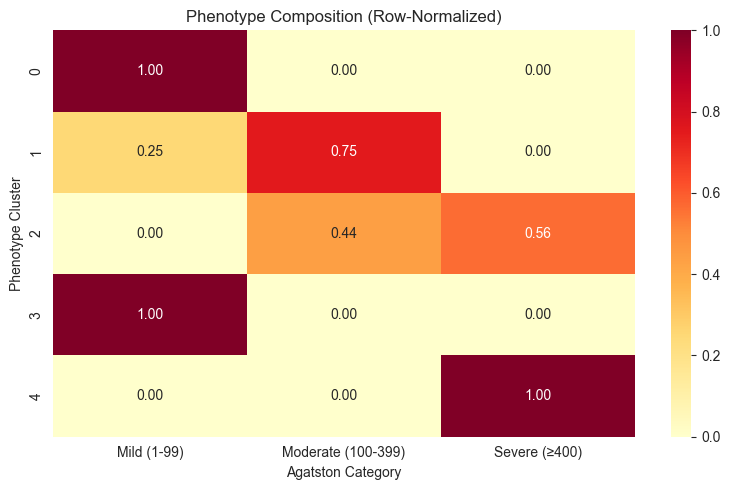

In [77]:
crosstab = pd.crosstab(features_df['cluster_kmeans'], features_df['agatston_label'], margins=True)
print("Phenotype × Agatston crosstab:")
print(crosstab)

fig, ax = plt.subplots(figsize=(8, 5))
ct_norm = pd.crosstab(features_df['cluster_kmeans'], features_df['agatston_label'], normalize='index')
sns.heatmap(ct_norm, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax)
ax.set_xlabel('Agatston Category')
ax.set_ylabel('Phenotype Cluster')
ax.set_title('Phenotype Composition (Row-Normalized)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'phenotype_agatston_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [78]:
kw_cluster = []
for feat in feature_cols:
    groups = [features_df[features_df['cluster_kmeans'] == c][feat].dropna().values for c in range(optimal_k)]
    groups = [g for g in groups if len(g) >= 2]
    if len(groups) < 2:
        continue
    h_stat, pval = stats.kruskal(*groups)
    kw_cluster.append({'feature': feat, 'h_stat': h_stat, 'p_value': pval})

kw_cluster_df = pd.DataFrame(kw_cluster).sort_values('h_stat', ascending=False)
print("Top features distinguishing phenotypes:")
for _, row in kw_cluster_df.head(10).iterrows():
    sig = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else 'ns'
    print(f"  {row['feature']}: H={row['h_stat']:.2f}, p={row['p_value']:.4f} {sig}")

Top features distinguishing phenotypes:
  glrlm_ShortRunEmphasis: H=23.03, p=0.0000 ***
  glcm_JointEntropy: H=23.03, p=0.0000 ***
  glcm_Idm: H=23.03, p=0.0000 ***
  glcm_Contrast: H=22.76, p=0.0000 ***
  glrlm_RunPercentage: H=22.54, p=0.0001 ***
  glcm_ClusterShade: H=20.58, p=0.0001 ***
  glrlm_RunEntropy: H=20.27, p=0.0001 ***
  glszm_GrayLevelNonUniformity: H=19.97, p=0.0002 ***
  shape_Sphericity: H=19.75, p=0.0002 ***
  glcm_Correlation: H=19.47, p=0.0002 ***


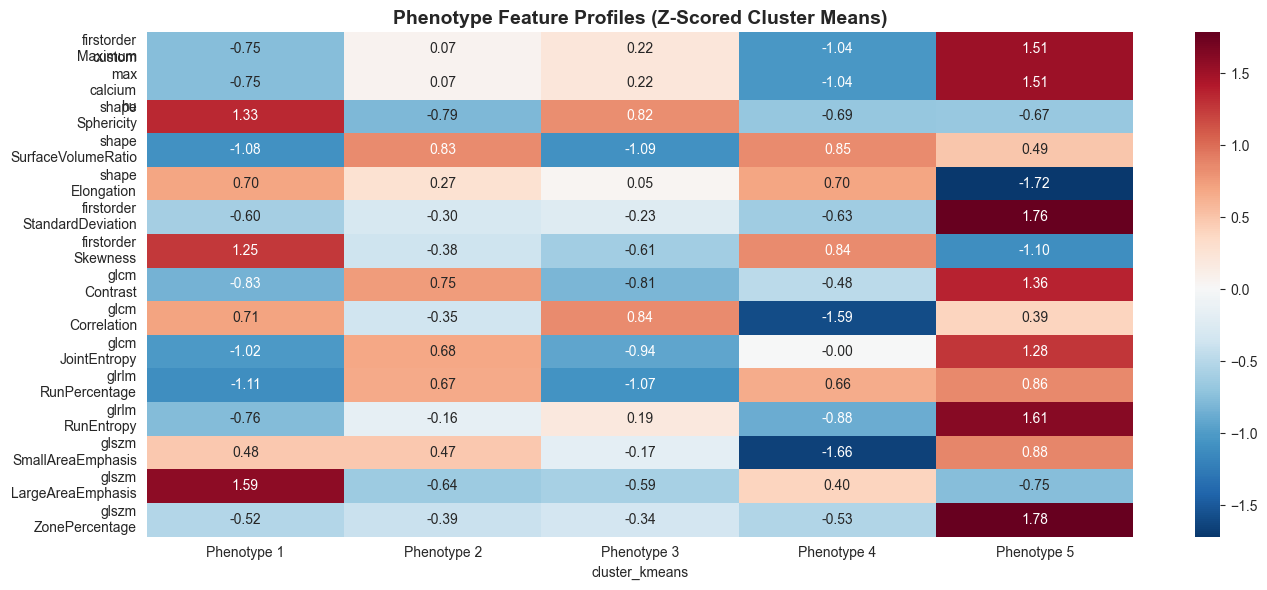

In [79]:
cluster_profiles = features_df.groupby('cluster_kmeans')[list(non_constant)].mean()
cluster_profiles_z = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()
top_var_features = cluster_profiles_z.std(axis=0).nlargest(15).index

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(cluster_profiles_z[top_var_features].T, cmap='RdBu_r', center=0,
            annot=True, fmt='.2f',
            xticklabels=[f'Phenotype {i+1}' for i in range(optimal_k)],
            yticklabels=[f.replace('_', '\n') for f in top_var_features], ax=ax)
ax.set_title('Phenotype Feature Profiles (Z-Scored Cluster Means)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'phenotype_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

In [80]:
for c in range(optimal_k):
    cluster_data = features_df[features_df['cluster_kmeans'] == c]
    print(f" Phenotype {c+1} (n={len(cluster_data)})")
    print(f"  Agatston: mean={cluster_data['agatston_score'].mean():.1f}, "
          f"median={cluster_data['agatston_score'].median():.1f}, "
          f"range=[{cluster_data['agatston_score'].min():.1f}, {cluster_data['agatston_score'].max():.1f}]")
    print(f"  Categories: {dict(cluster_data['agatston_label'].value_counts())}")

    cluster_means = cluster_data[list(non_constant)].mean()
    overall_means = features_df[list(non_constant)].mean()
    overall_stds = features_df[list(non_constant)].std()
    z_scores = (cluster_means - overall_means) / overall_stds.clip(1e-10)

    top_high = z_scores.nlargest(3)
    top_low = z_scores.nsmallest(3)
    print(f"  Elevated:  {', '.join([f'{k.split(chr(95))[-1]}(z={v:+.1f})' for k, v in top_high.items()])}")
    print(f"  Reduced:   {', '.join([f'{k.split(chr(95))[-1]}(z={v:+.1f})' for k, v in top_low.items()])}")

 Phenotype 1 (n=4)
  Agatston: mean=18.6, median=10.9, range=[0.9, 51.8]
  Categories: {'Mild (1-99)': np.int64(4)}
  Elevated:  mm3(z=+1.9), LargeAreaEmphasis(z=+1.6), Skewness(z=+1.5)
  Reduced:   mm(z=-1.5), mm(z=-1.2), ShortRunEmphasis(z=-1.2)
 Phenotype 2 (n=4)
  Agatston: mean=190.7, median=219.6, range=[32.5, 291.1]
  Categories: {'Moderate (100-399)': np.int64(3), 'Mild (1-99)': np.int64(1)}
  Elevated:  Contrast(z=+1.8), JointEntropy(z=+1.7), ShortRunEmphasis(z=+1.5)
  Reduced:   Idm(z=-1.5), Sphericity(z=-1.4), MeshVolume(z=-0.9)
 Phenotype 3 (n=16)
  Agatston: mean=627.2, median=413.3, range=[116.3, 2753.2]
  Categories: {'Severe (≥400)': np.int64(9), 'Moderate (100-399)': np.int64(7)}
  Elevated:  mm3(z=+0.7), MeshVolume(z=+0.7), Idm(z=+0.7)
  Reduced:   SurfaceVolumeRatio(z=-0.7), RunPercentage(z=-0.7), JointEntropy(z=-0.6)
 Phenotype 4 (n=5)
  Agatston: mean=4.1, median=3.7, range=[0.7, 9.4]
  Categories: {'Mild (1-99)': np.int64(5)}
  Elevated:  SurfaceVolumeRatio(z=+1.4